AlexNet is a convolutional neural network (CNN).
It was one of the first CNNs to demonstrate the effectiveness of deep learning for image classification tasks.

AlexNet is composed of 8 layers: 5 convolutional layers, 2 fully connected layers, and 1 softmax layer. It uses the Rectified Linear Unit (ReLU) activation function, local response normalization, and dropout regularization to prevent overfitting.

Firstly, it operated with 3-channel images that were (224x224x3) in size. It used max pooling along with ReLU activations when subsampling. The kernels used for convolutions were either 11x11, 5x5, or 3x3 while kernels used for max pooling were 3x3 in size. It classified images into 1000 classes. It also utilized multiple GPUs.

Source: https://blog.paperspace.com/alexnet-pytorch/

In [142]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn # For the dense layer

In [143]:
class AlexNet(nn.Module):
    def __init__(self, number_classes=10):

        super(AlexNet, self).__init__()
        self.number_classes = number_classes
        self.convolution_block1 = nn.Sequential(       # First convolution layer
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),  # 2D convolution layer, 3 channel image, applies 96 filters of size 11x11 with a stride of 4 and no padding
            nn.BatchNorm2d(96),                                     # Normalizing batch layer for the first convolution layer
            nn.ReLU(),                                              # ReLU is a non-linear activation function
            nn.MaxPool2d(kernel_size=2, stride = 2),                # reducing the spatial dimensions of the output tensor by half.
        )
        self.convolution_block2 = nn.Sequential(                    # Second convolution layer, to learn more complex and abstract features from the image.
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), # input tensor is the output from the first convolutional layer
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.convolution_block3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        
        self.convolution_block4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        
        self.convolution_block5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        # Fully connected layers,  to convert the high-dimensional output from the convolutional layers to a probability distribution over the possible classes.
        # used to prevent overfitting by randomly dropping out units during training
        # RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x256 and 9216x4096)
        self.fully_connected = nn.Sequential(                       
            nn.Dropout(0.5),                                        
            nn.Linear(256, 4096),
            nn.ReLU())
        self.fully_connected1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fully_connected2= nn.Sequential(                     
            nn.Linear(4096, number_classes))                        #Softmax function,  produces a probability distribution over the possible classes, allowing the network to make a prediction.         


    def forward(self, x):
        out = self.convolution_block1(x)
        out = self.convolution_block2(out)
        out = self.convolution_block3(out)
        out = self.convolution_block4(out)
        out = self.convolution_block5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fully_connected(out)
        out = self.fully_connected1(out)
        logits = self.fully_connected2(out)

        return logits      # class probabilites

In [144]:
model = AlexNet(number_classes=10)
print(model)
#model.convolution_block
#model.flatten
print(model.state_dict())

AlexNet(
  (convolution_block1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convolution_block2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convolution_block3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convolution_block4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convolution_block5): Sequential

Setting Hyperparameters

In [145]:
# The optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, weight_decay = 0.005, momentum = 0.9) 

In [146]:
# The loss
loss_fn1 = nn.MSELoss()
loss_fn2 = nn.CrossEntropyLoss()       # Criterion

In [147]:
from torchvision import transforms
from torchvision import datasets


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader

In [148]:
def train(dataloader, model, loss_fns, optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader): # y : GT
        pred = model(X)
        loss_sum = 0.0
        for loss_fn in loss_fns:
          pred_max, max_indices = torch.max(pred, dim=1)
          pred_max = pred_max.to(torch.float)
          y = y.to(torch.float)
          loss_sum += loss_fn(pred_max, y)

        optimizer.zero_grad()
        loss_sum = loss_sum.to(torch.float)
        loss_sum.backward()
        optimizer.step()

        train_loss += loss_sum
        if batch % 1000 == 0:
            loss, current = loss_sum.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= len(dataloader)
    return train_loss

In [149]:
def test(dataloader, model, loss_fns):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad(): # To freeze the network
        for X, y in dataloader:
            pred = model(X)
            test_loss_sum = 0.0
            for loss_fn in loss_fns: 
                pred_max, max_indices = torch.max(pred, dim=1)
                test_loss_sum += loss_fn(pred_max, y).item()
            test_loss += test_loss_sum
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # calculating number of batches

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [150]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.CIFAR10(root="../data/cifar10/", train=True, download=False, transform=ToTensor())

test_data = datasets.CIFAR10(root="../data/cifar10/", train=False, download=False, transform=ToTensor())

In [151]:
from torch.utils.data import DataLoader
import torch.utils.data as data_utils

indices = torch.arange(0,1000)
training_data = data_utils.Subset(training_data, indices)

indices = torch.arange(0,100)
test_data = data_utils.Subset(test_data, indices)

BATCH_SIZE = 64

loaded_train = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
loaded_test = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [152]:
def eval_net(model, loss_fns, optimizer, num_epochs = 5):
    train_losses = []
    test_losses = []
    accuracy_scores = []

    for t in range(num_epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(loaded_train, model, loss_fns, optimizer)
        train_loss = train_loss.detach().numpy()
        test_loss, accuracy = test(loaded_test, model, loss_fns)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        accuracy_scores.append(accuracy)
    print("Done!")

    fig,axs = plt.subplots(1, 2, figsize=(8,8))
    axs = axs.ravel()
    axs[0].plot(range(num_epochs), train_losses, ":r")
    axs[0].plot(range(num_epochs), test_losses, "-b")

    axs[1].plot(range(num_epochs), accuracy_scores)

Epoch 1
-------------------------------
loss: 27.438444  [    0/ 1000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 8.606432 

Epoch 2
-------------------------------
loss: 9.028630  [    0/ 1000]
Test Error: 
 Accuracy: 9.0%, Avg loss: 8.596864 

Epoch 3
-------------------------------
loss: 9.337622  [    0/ 1000]
Test Error: 
 Accuracy: 8.0%, Avg loss: 8.247369 

Epoch 4
-------------------------------
loss: 6.779070  [    0/ 1000]
Test Error: 
 Accuracy: 8.0%, Avg loss: 7.445904 

Epoch 5
-------------------------------
loss: 4.487786  [    0/ 1000]
Test Error: 
 Accuracy: 8.0%, Avg loss: 8.542573 

Epoch 6
-------------------------------
loss: 5.276890  [    0/ 1000]
Test Error: 
 Accuracy: 8.0%, Avg loss: 9.938127 

Epoch 7
-------------------------------
loss: 4.804571  [    0/ 1000]
Test Error: 
 Accuracy: 8.0%, Avg loss: 11.655032 

Epoch 8
-------------------------------
loss: 4.890265  [    0/ 1000]
Test Error: 
 Accuracy: 8.0%, Avg loss: 8.504561 

Epoch 9
---------------------

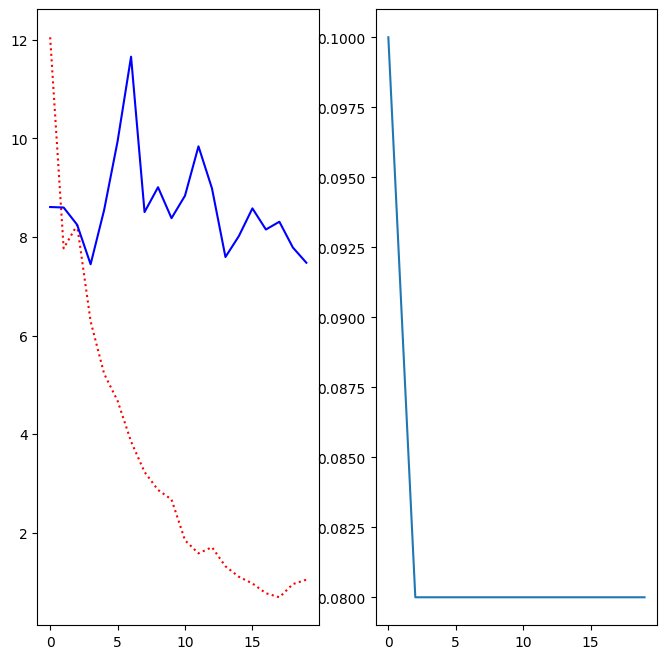

In [153]:
eval_net(model, loss_fns=[loss_fn1], optimizer=optimizer, num_epochs=20)

In [154]:
training_data.dataset.data.shape

(50000, 32, 32, 3)